In [47]:
# create configs for UKB age regression / classification.
# classification to get higher signal ?
# compare 1000 youngest to 1000 oldest
# compare 1000 youngest to 1000 in the middle ? Because oldest may have altered patterns, whereas 60 years old shouldn't ...
# stratify male female ?
# extend by quantile ? 200 of each 10% quantile ? or 5 years gaps

In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# linear classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [81]:
participants = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/participants_sex_age.csv')

(array([  74., 1005., 2098., 2343., 2160., 3330., 3908., 3205., 1688.,
         397.]),
 array([44. , 47.8, 51.6, 55.4, 59.2, 63. , 66.8, 70.6, 74.4, 78.2, 82. ]),
 <BarContainer object of 10 artists>)

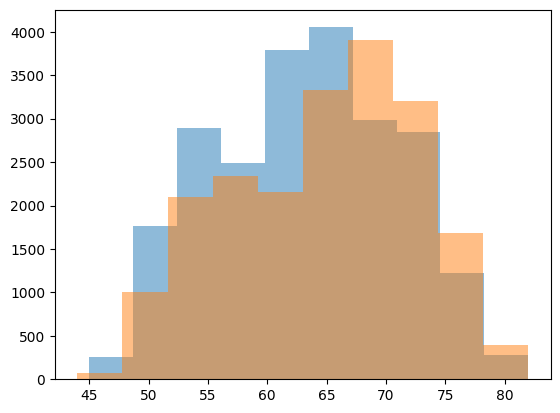

In [82]:
## correlation between age and sex

plt.hist(participants.loc[participants['Sex']==0]['Age'], alpha=0.5)
plt.hist(participants.loc[participants['Sex']==1]['Age'], alpha=0.5)

In [83]:
# separate male / female
quantiles = participants['Age'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1])
print(quantiles)
print(participants['Age'].min(), participants['Age'].max())

0.10    53.0
0.20    56.0
0.30    59.0
0.40    62.0
0.50    64.0
0.60    67.0
0.70    69.0
0.80    71.0
0.90    74.0
0.95    76.0
1.00    82.0
Name: Age, dtype: float64
44.0 82.0


In [84]:
age_increment = 5
mini, maxi = int(participants['Age'].min()), int(participants['Age'].max())

for sex in [0, 1]:
    selected_participants = participants.loc[participants['Sex']==sex]
    for age in range(mini, maxi, age_increment):
        # get the participants in this age range
        print(age, age + age_increment)
        age_range = selected_participants.loc[(selected_participants['Age'] >= age) & (selected_participants['Age'] < age + age_increment)]
        # restrict to 200 participants
        age_range = age_range.sample(min(200, len(age_range)), random_state=42)
        print(age_range)
        # save the list of participants
        age_range.to_csv(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/age_ranges/sex{sex}_age_{age}_{age + age_increment}.csv', index=False)

44 49
           Subject  Sex   Age
34638  sub-4183098    0  48.0
520    sub-1239967    0  46.0
14955  sub-3365556    0  47.0
34427  sub-3097304    0  48.0
19529  sub-2894416    0  47.0
...            ...  ...   ...
37240  sub-2122201    0  48.0
21523  sub-2217188    0  48.0
3074   sub-2569201    0  48.0
27869  sub-3354303    0  48.0
13387  sub-3195822    0  47.0

[200 rows x 3 columns]
49 54
           Subject  Sex   Age
22896  sub-5736953    0  49.0
17651  sub-4284353    0  53.0
41320  sub-3630577    0  52.0
11751  sub-4347758    0  51.0
11034  sub-5366951    0  49.0
...            ...  ...   ...
7812   sub-6019097    0  52.0
40345  sub-1980594    0  50.0
4880   sub-1108605    0  49.0
35910  sub-1427957    0  51.0
32679  sub-5974748    0  51.0

[200 rows x 3 columns]
54 59
           Subject  Sex   Age
34971  sub-5125436    0  54.0
41455  sub-4192908    0  54.0
22533  sub-2462690    0  56.0
27236  sub-5854343    0  54.0
16636  sub-5755913    0  57.0
...            ...  ...   ...
5709

In [ ]:
## load ukb embeddings
model = '/neurospin/dico/jlaval/Output/ablation_2_models_combinations/compare_trim_no_trim/SOr_left_UKB40/trim'
ukb_embeddings = pd.read_csv(os.path.join(model, 'ukb40_random_embeddings/full_embeddings.csv'))
ukb_embeddings = ukb_embeddings.drop_duplicates(ignore_index=True)
ukb_embeddings.columns = ['Subject'] + [f'dim{i}' for i in range(ukb_embeddings.shape[1] - 1)]

In [122]:
# load pair of subsets
age1 = 44
age2 = 54
subs1 = pd.read_csv(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/age_ranges/sex{sex}_age_{age1}_{age1 + age_increment}.csv', usecols=['Subject'])
subs2 = pd.read_csv(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/age_ranges/sex{sex}_age_{age2}_{age2 + age_increment}.csv', usecols=['Subject'])

In [123]:
# concat the sets of subs with one label for each set
subs1['label'] = 0
subs2['label'] = 1
subs = pd.concat([subs1, subs2], ignore_index=True)
# merge with the embeddings
ukb_embeddings = pd.merge(ukb_embeddings, subs, left_on='Subject', right_on='Subject', how='inner')

In [124]:
# define X and y for linear classification
X = ukb_embeddings.iloc[:, 1:-1].values
y = ukb_embeddings.iloc[:, -1].values
# check the number of samples
print(X.shape, y.shape)
# check the number of samples in each class
print(np.unique(y, return_counts=True))

(390, 32) (390,)
(array([0, 1]), array([190, 200]))


In [125]:
parameters={'l1_ratio': np.linspace(0,1,11), 'C': [10**k for k in range(-3,4)]}
model = LogisticRegression(solver='saga', penalty='elasticnet',
                           max_iter=10000, random_state=42, class_weight='balanced')
clf = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True, n_jobs=46)
clf.fit(X, y)
print(f'best params : {clf.best_params_}')
print(f'best score : {clf.best_score_}')

best params : {'C': 0.1, 'l1_ratio': 0.0}
best score : 0.5653947368421053


## LOOP

In [214]:
# loop on models, but also on regions
n_ranges=8
regions = ['SOr_left_UKB40', 'FIP_right_UKB40', 'SC-sylv_left_UKB40', 'LARGE_CINGULATE_right_UKB40']
sexes = [0, 1]
df = pd.DataFrame({region : {sex: 0 for sex in [0,1]} for region in regions}, dtype=object)

model_root = '/neurospin/dico/jlaval/Output/ablation_2_models_combinations/combinations_with_trim'
#model_name = '4_best_with_trimdepth_4mm'
model_name = '3_best_with_trimextremities_trimdepth_4mm'

for region in regions:
    print(region)
    for sex in sexes:
        print(sex)
        mat = np.full((n_ranges, n_ranges), fill_value = 0.5)
        # find the model
        list_path = os.listdir(os.path.join(model_root, region))
        model_full_name = next(x for x in list_path if x.startswith(model_name))
        model_path = os.path.join(model_root, region, model_full_name)

        for i, age1 in enumerate(range(mini,maxi,age_increment)):
            for j, age2 in enumerate(range(age1+age_increment,maxi,age_increment)):
                ukb_embeddings = pd.read_csv(os.path.join(model_path, 'ukb40_random_embeddings/full_embeddings.csv'))
                ukb_embeddings = ukb_embeddings.drop_duplicates(ignore_index=True)
                ukb_embeddings.columns = ['Subject'] + [f'dim{i}' for i in range(ukb_embeddings.shape[1] - 1)]

                print(f'Comparing {[age1, age1+age_increment]} - {[age2, age2+age_increment]}')
                # load pair of subsets
                subs1 = pd.read_csv(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/age_ranges/sex{sex}_age_{age1}_{age1 + age_increment}.csv', usecols=['Subject'])
                subs2 = pd.read_csv(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/age_ranges/sex{sex}_age_{age2}_{age2 + age_increment}.csv', usecols=['Subject'])

                # concat the sets of subs with one label for each set
                subs1['label'] = 0
                subs2['label'] = 1
                subs = pd.concat([subs1, subs2], ignore_index=True)
                # merge with the embeddings
                ukb_embeddings = pd.merge(ukb_embeddings, subs, left_on='Subject', right_on='Subject', how='inner')

                # define X and y for linear classification
                X = ukb_embeddings.iloc[:, 1:-1].values
                y = ukb_embeddings.iloc[:, -1].values

                parameters={'l1_ratio': np.linspace(0,1,11), 'C': [10**k for k in range(-3,4)]}
                model = LogisticRegression(solver='saga', penalty='elasticnet',
                                        max_iter=10000, random_state=42, class_weight='balanced')
                clf = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True, n_jobs=46)
                clf.fit(X, y)
                print(f'best params : {clf.best_params_}')
                print(f'best score : {clf.best_score_}')
                mat[i,i+j+1] = clf.best_score_
                mat[i+j+1,i] = clf.best_score_
        df[region][sex]=mat

SOr_left_UKB40
0
Comparing [44, 49] - [49, 54]
best params : {'C': 0.001, 'l1_ratio': 0.6000000000000001}
best score : 0.5
Comparing [44, 49] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.5}
best score : 0.5
Comparing [44, 49] - [59, 64]
best params : {'C': 0.01, 'l1_ratio': 0.0}
best score : 0.5172564102564103
Comparing [44, 49] - [64, 69]
best params : {'C': 0.01, 'l1_ratio': 0.5}
best score : 0.5917435897435898
Comparing [44, 49] - [69, 74]
best params : {'C': 10, 'l1_ratio': 0.1}
best score : 0.6653621794871795
Comparing [44, 49] - [74, 79]
best params : {'C': 0.1, 'l1_ratio': 0.1}
best score : 0.6588301282051282
Comparing [44, 49] - [79, 84]
best params : {'C': 1, 'l1_ratio': 0.7000000000000001}
best score : 0.7163557692307693
Comparing [49, 54] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.4}
best score : 0.5
Comparing [49, 54] - [59, 64]
best params : {'C': 0.1, 'l1_ratio': 0.8}
best score : 0.5237756410256409
Comparing [49, 54] - [64, 69]
best params : {'C': 0.01, '

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.001, 'l1_ratio': 0.30000000000000004}
best score : 0.503087044534413
Comparing [44, 49] - [54, 59]
best params : {'C': 0.01, 'l1_ratio': 0.2}
best score : 0.5023684210526316
Comparing [44, 49] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.2}
best score : 0.5241565452091768
Comparing [44, 49] - [64, 69]
best params : {'C': 10, 'l1_ratio': 0.2}
best score : 0.6216173023652248
Comparing [44, 49] - [69, 74]
best params : {'C': 0.01, 'l1_ratio': 0.0}
best score : 0.6513900134952767
Comparing [44, 49] - [74, 79]
best params : {'C': 0.01, 'l1_ratio': 0.1}
best score : 0.6580904183535762
Comparing [44, 49] - [79, 84]
best params : {'C': 0.01, 'l1_ratio': 0.0}
best score : 0.7057624831309042
Comparing [49, 54] - [54, 59]
best params : {'C': 0.01, 'l1_ratio': 0.9}
best score : 0.5386217948717948
Comparing [49, 54] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.1}
best score : 0.5203648915187377
Comparing [49, 54] - [64, 69]
best para

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.001, 'l1_ratio': 0.6000000000000001}
best score : 0.5
Comparing [44, 49] - [54, 59]
best params : {'C': 1, 'l1_ratio': 0.2}
best score : 0.5457916666666668
Comparing [44, 49] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.4}
best score : 0.5455128205128206
Comparing [44, 49] - [64, 69]
best params : {'C': 1, 'l1_ratio': 0.2}
best score : 0.5232051282051282
Comparing [44, 49] - [69, 74]
best params : {'C': 0.1, 'l1_ratio': 0.30000000000000004}
best score : 0.6511666666666667
Comparing [44, 49] - [74, 79]
best params : {'C': 1, 'l1_ratio': 1.0}
best score : 0.6148076923076923
Comparing [44, 49] - [79, 84]
best params : {'C': 0.1, 'l1_ratio': 0.5}
best score : 0.6945897435897436
Comparing [49, 54] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.6000000000000001}
best score : 0.5
Comparing [49, 54] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.30000000000000004}
best score : 0.5087243589743589
Comparing [49, 54] - [64, 69]


/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.001, 'l1_ratio': 0.6000000000000001}
best score : 0.5703812415654521
Comparing [44, 49] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.8}
best score : 0.6163157894736842
Comparing [44, 49] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.30000000000000004}
best score : 0.5651821862348179
Comparing [44, 49] - [64, 69]
best params : {'C': 0.001, 'l1_ratio': 0.7000000000000001}
best score : 0.6259357908942397
Comparing [44, 49] - [69, 74]
best params : {'C': 0.001, 'l1_ratio': 0.2}
best score : 0.5855229419703104
Comparing [44, 49] - [74, 79]
best params : {'C': 10, 'l1_ratio': 0.4}
best score : 0.662567476383266
Comparing [44, 49] - [79, 84]
best params : {'C': 0.1, 'l1_ratio': 1.0}
best score : 0.7094568151147099
Comparing [49, 54] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.8}
best score : 0.5
Comparing [49, 54] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.30000000000000004}
best score : 0.5224950690335306
Compa

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.01, 'l1_ratio': 0.2}
best score : 0.5814519230769231
Comparing [44, 49] - [54, 59]
best params : {'C': 0.01, 'l1_ratio': 0.2}
best score : 0.5695352564102565
Comparing [44, 49] - [59, 64]
best params : {'C': 0.1, 'l1_ratio': 1.0}
best score : 0.6054551282051281
Comparing [44, 49] - [64, 69]
best params : {'C': 0.1, 'l1_ratio': 0.4}
best score : 0.5804391025641026
Comparing [44, 49] - [69, 74]
best params : {'C': 10, 'l1_ratio': 0.0}
best score : 0.5697147435897436
Comparing [44, 49] - [74, 79]
best params : {'C': 0.1, 'l1_ratio': 0.8}
best score : 0.623698717948718
Comparing [44, 49] - [79, 84]
best params : {'C': 100, 'l1_ratio': 0.0}
best score : 0.6156602564102565
Comparing [49, 54] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.0}
best score : 0.5189519230769231
Comparing [49, 54] - [59, 64]
best params : {'C': 0.01, 'l1_ratio': 0.2}
best score : 0.5593750000000001
Comparing [49, 54] - [64, 69]
best params : {'C': 0.1, 'l1_ra

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.001, 'l1_ratio': 0.6000000000000001}
best score : 0.5
Comparing [44, 49] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.2}
best score : 0.500263157894737
Comparing [44, 49] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.5}
best score : 0.5645074224021591
Comparing [44, 49] - [64, 69]
best params : {'C': 0.001, 'l1_ratio': 0.2}
best score : 0.5443532921372256
Comparing [44, 49] - [69, 74]
best params : {'C': 100, 'l1_ratio': 0.0}
best score : 0.5342408906882591
Comparing [44, 49] - [74, 79]
best params : {'C': 10, 'l1_ratio': 0.8}
best score : 0.5517712550607288
Comparing [44, 49] - [79, 84]
best params : {'C': 10, 'l1_ratio': 0.5}
best score : 0.591808367071525
Comparing [49, 54] - [54, 59]
best params : {'C': 0.1, 'l1_ratio': 0.6000000000000001}
best score : 0.5280448717948718
Comparing [49, 54] - [59, 64]
best params : {'C': 1, 'l1_ratio': 0.2}
best score : 0.5767652859960553
Comparing [49, 54] - [64, 69]
best params : {'C

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.1, 'l1_ratio': 1.0}
best score : 0.521875
Comparing [44, 49] - [54, 59]
best params : {'C': 0.1, 'l1_ratio': 0.8}
best score : 0.5257532051282051
Comparing [44, 49] - [59, 64]
best params : {'C': 0.1, 'l1_ratio': 0.2}
best score : 0.5978717948717949
Comparing [44, 49] - [64, 69]
best params : {'C': 0.001, 'l1_ratio': 0.0}
best score : 0.5594358974358975
Comparing [44, 49] - [69, 74]
best params : {'C': 0.001, 'l1_ratio': 0.6000000000000001}
best score : 0.6609102564102564
Comparing [44, 49] - [74, 79]
best params : {'C': 0.01, 'l1_ratio': 0.30000000000000004}
best score : 0.7108333333333332
Comparing [44, 49] - [79, 84]
best params : {'C': 0.01, 'l1_ratio': 0.5}
best score : 0.7791474358974358
Comparing [49, 54] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.8}
best score : 0.5226987179487179
Comparing [49, 54] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.30000000000000004}
best score : 0.563724358974359
Comparing [49, 54]

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


Comparing [44, 49] - [49, 54]
best params : {'C': 0.01, 'l1_ratio': 0.9}
best score : 0.5165856950067476
Comparing [44, 49] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.1}
best score : 0.49131578947368426
Comparing [44, 49] - [59, 64]
best params : {'C': 0.01, 'l1_ratio': 1.0}
best score : 0.6098515519568152
Comparing [44, 49] - [64, 69]
best params : {'C': 0.01, 'l1_ratio': 0.9}
best score : 0.6233042119468712
Comparing [44, 49] - [69, 74]
best params : {'C': 0.1, 'l1_ratio': 0.30000000000000004}
best score : 0.6896862348178138
Comparing [44, 49] - [74, 79]
best params : {'C': 0.01, 'l1_ratio': 0.4}
best score : 0.7186909581646423
Comparing [44, 49] - [79, 84]
best params : {'C': 0.01, 'l1_ratio': 0.0}
best score : 0.8186302294197031
Comparing [49, 54] - [54, 59]
best params : {'C': 0.001, 'l1_ratio': 0.5}
best score : 0.48321153846153847
Comparing [49, 54] - [59, 64]
best params : {'C': 0.001, 'l1_ratio': 0.5}
best score : 0.6185075608152533
Comparing [49, 54] - [64, 69]
best 

/tmp/ipykernel_397440/4132017617.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[region][sex]=mat


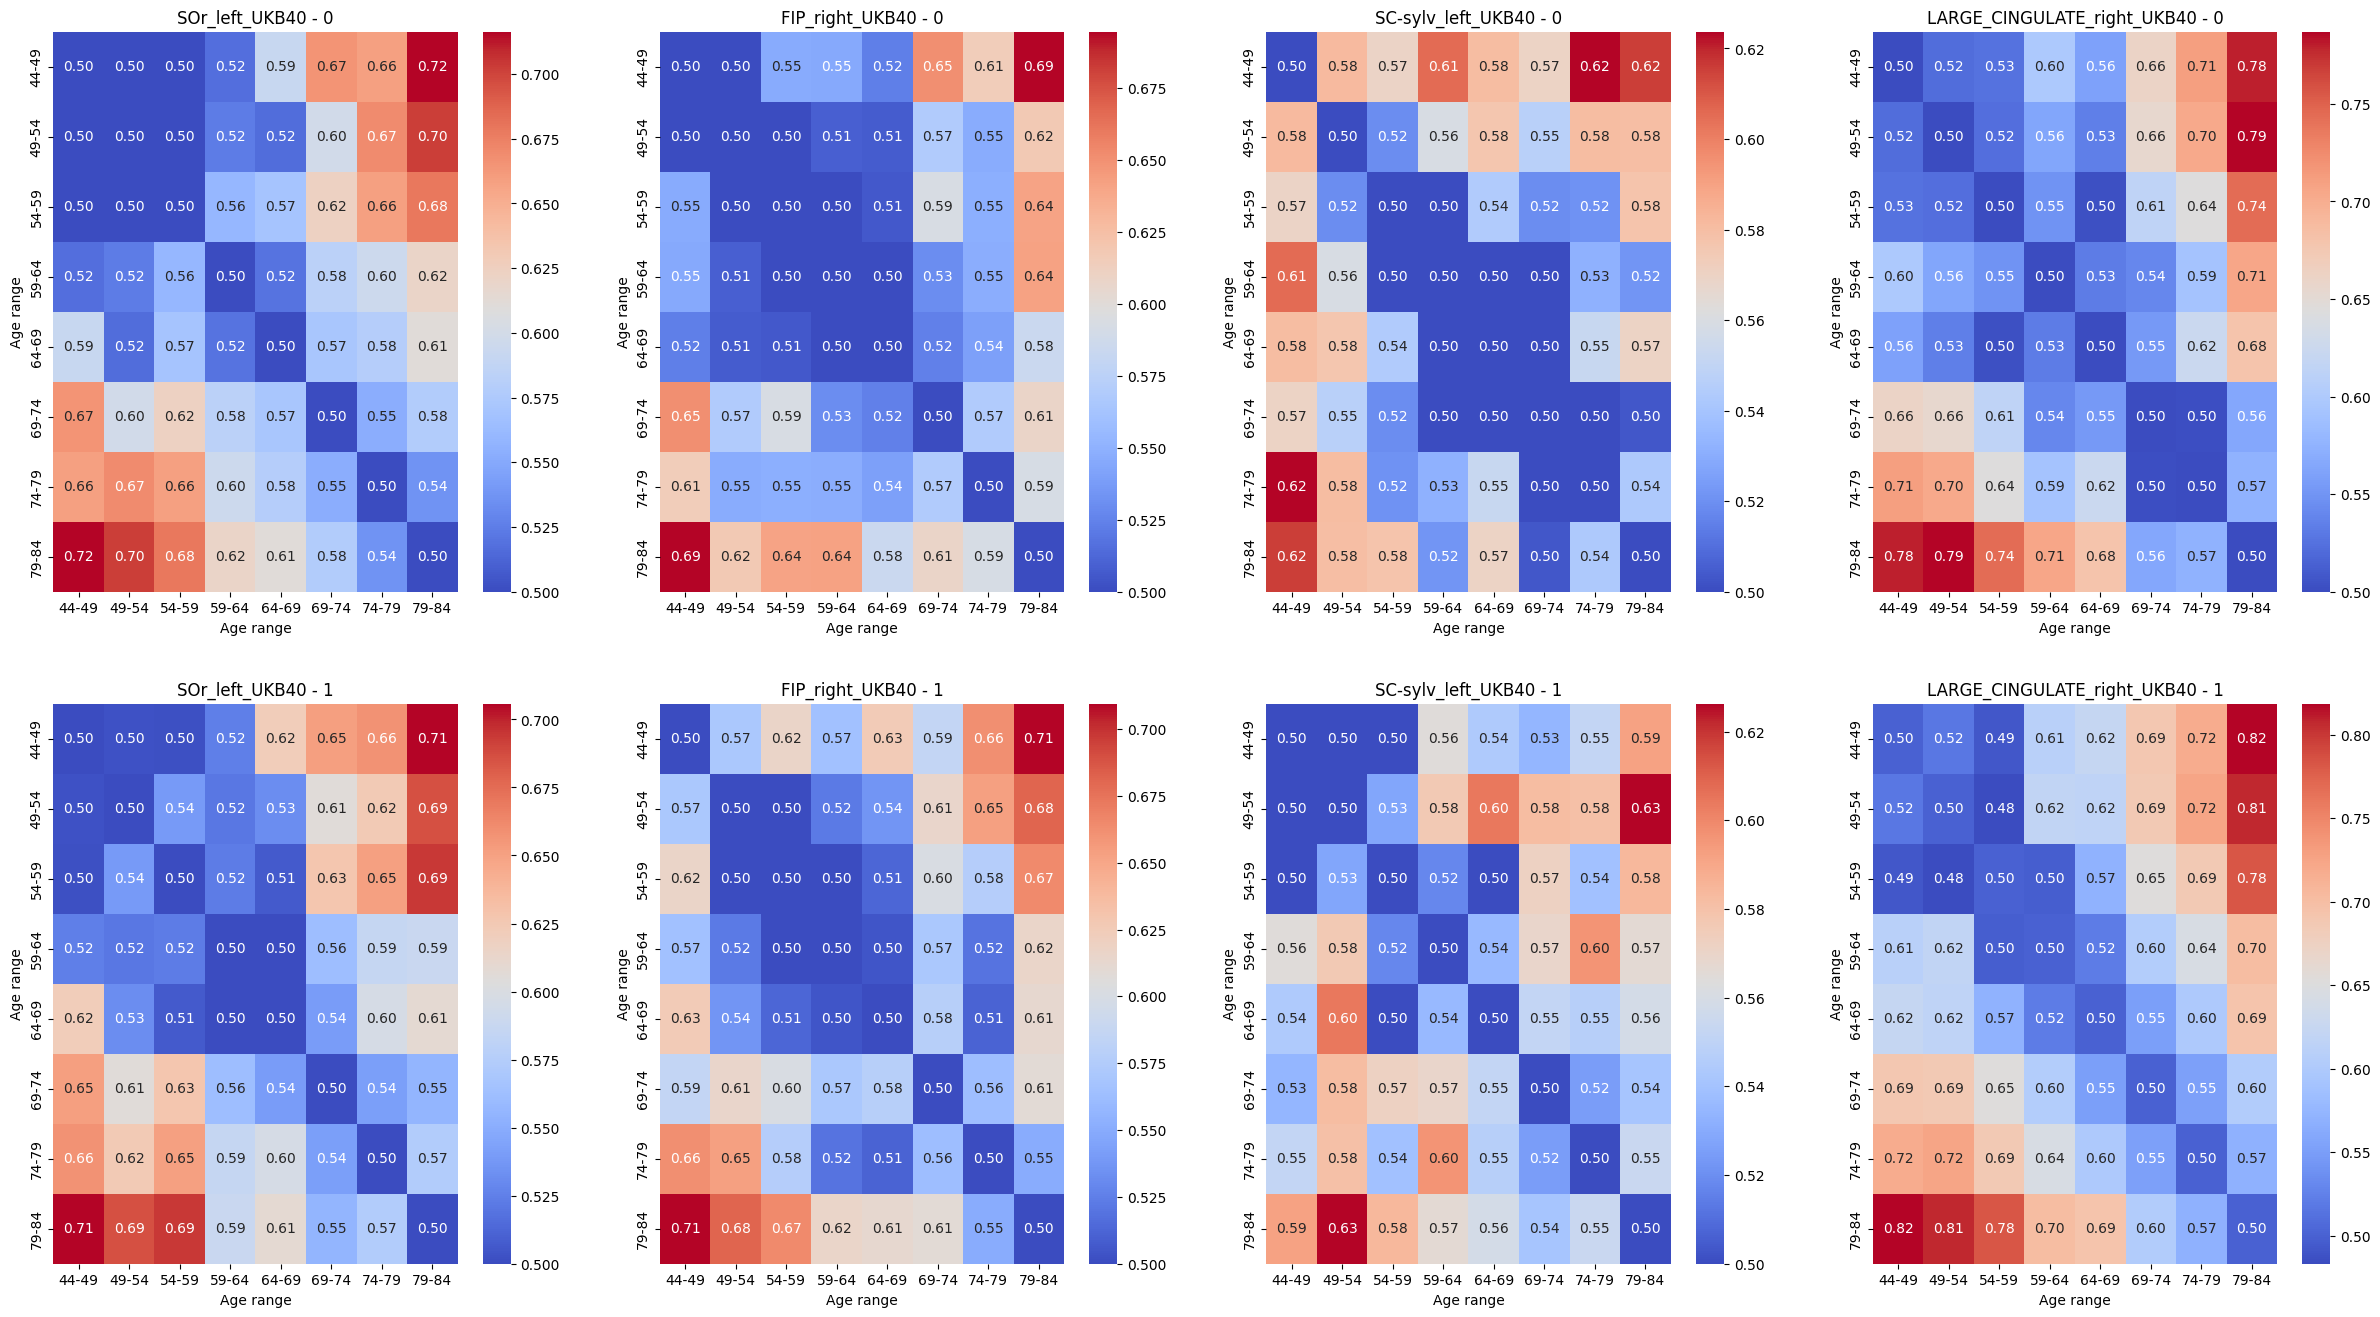

In [215]:
# plot the results
# one matrix for each sex
import seaborn as sns

ticks = []
for i in range(mini, maxi, age_increment):
    ticks.append(f'{i}-{i+age_increment}')
ticks = np.array(ticks)

fig, axs = plt.subplots(2, 4, figsize=(30, 16))

for i in range(2):
    for j in range(4):
        ax = axs[i,j]
        mat = df.iloc[i,j]
        for k in range(8): # make sure the diagonal is 0.5
            mat[k,k] = 0.5
        g = sns.heatmap(mat, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, cbar=True)
        g.set_xticklabels(ticks)
        g.set_yticklabels(ticks)
        ax.set_xlabel('Age range')
        ax.set_ylabel('Age range')
        ax.set_title(f'{regions[j]} - {sexes[i]}')
plt.savefig(os.path.join(model_root, f'{model_name}_classify_age_{age_increment}_interval.png'))

plt.show()